In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=4, threads_per_worker=1,  memory_limit='6GB')
client = Client(cluster)

In [ ]:
from tropical_cyclones import TCs, multi_plot, plot_trajectories
from aqua.core.util import load_yaml

config = load_yaml('/home/mccorda/work/tc_analysis3/config_tcs_yearlystitch.yaml')

/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/intake_esm/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
# initialise tropical class with streaming options
tropical = TCs(tdict=config, streaming=True,
                stream_step=config['stream']['streamstep'],
                stream_startdate=config['time']['startdate'],
                paths=config['paths'],
                loglevel=config['setup']['loglevel'],
                orography=True,
                nproc=1)

2026-02-06 16:50:12 :: TCs :: WARNING  -> Model ERA5 - Exp: era5
2026-02-06 16:50:12 :: TCs :: WARNING  -> Initialised streaming for 1D days starting on 1979-01-01 00:00:00


In [4]:
# ===========================================
# 1. SETUP - Parametri da config
# ===========================================
import os
from glob import glob
from datetime import datetime

trackdir = config['paths']['trackdir']
tmpdir = config['paths']['tmpdir']
era5_dir = "/work/users/mccorda/data"
start_date = datetime.strptime(config['time']['startdate'], "%Y%m%d")
end_date   = datetime.strptime(config['time']['enddate'], "%Y%m%d")

In [5]:
# ===========================================
# 2. SELEZIONE FILE - Trova i file tempest_track nel range di date
# ===========================================
all_files = sorted(glob(os.path.join(trackdir, "tempest_track_*.txt")))
filenames = []
for f in all_files:
    base = os.path.basename(f)
    try:
        parts = base.replace("tempest_track_", "").replace(".txt", "").split("-")
        start_f = datetime.strptime(parts[0], "%Y%m%d")
        end_f = datetime.strptime(parts[1], "%Y%m%d")
        if end_f >= start_date and start_f <= end_date:
            filenames.append(f)
    except:
        pass

print(f"[INFO] File selezionati: {len(filenames)}")

[INFO] File selezionati: 790


In [6]:
# ===========================================
# 3. MERGE FILE - CON STORM_ID UNICI
# ===========================================
os.makedirs(tmpdir, exist_ok=True)
tot_file = os.path.join(tmpdir, f"tempest_tracks_tot_{config['time']['startdate']}_{config['time']['enddate']}.txt")

global_storm_id = 0  # Contatore globale

with open(tot_file, 'w') as output_file:
    output_file.write("track_id year month day hour i j lon lat slp wind zs\n")
    
    for fname in filenames:
        with open(fname, 'r') as infile:
            lines = infile.readlines()
            
            if len(lines) == 0:
                print(f"[WARNING] File vuoto: {fname}")
                continue
            
            # Mappa storm_id locali -> storm_id globali
            local_to_global = {}
            
            for line in lines[1:]:  # Skippa header
                clean = line.replace(',', '').strip()
                if not clean:
                    continue
                parts = clean.split()
                if len(parts) != 12:
                    continue
                
                local_id = parts[0]
                
                # Assegna nuovo ID globale se è la prima volta che vediamo questo local_id
                if local_id not in local_to_global:
                    local_to_global[local_id] = str(global_storm_id)
                    global_storm_id += 1
                
                # Sostituisci con ID globale
                parts[0] = local_to_global[local_id]
                output_file.write(" ".join(parts) + "\n")

print(f"[INFO] File totale creato: {tot_file}")
print(f"[INFO] Totale storm unici: {global_storm_id}")

[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_19840430-19840529.txt
[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_19880430-19880529.txt
[WARNING] File vuoto: /work/users/mccorda/tc_analysis/trackdir/ERA5/era5/tempest_track_20050501-20050530.txt
[INFO] File totale creato: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150606.txt
[INFO] Totale storm unici: 2380


In [7]:
# ===========================================
# 4. FILTRO STJ - Applica il filtro 
# ===========================================
import sys
import os

# ============================================================
#   STJ Filter (versione adattata ai dati 250 hPa)
#   Basato sul metodo di Bourdin et al. (2022)
#   Versione semplificata: climatologia mensile, soglie su U e V,
#   jet-lat trovato come massimo del profilo del wind speed.
#   FIX: gestisce sia spazi che virgole come separatori
# ============================================================

# Path TCs_filter.py
custom_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/tools/'
if custom_path not in sys.path:
    sys.path.insert(0, custom_path)

# Import the filter
from TCs_filter import filter_STJ_Bourdin250_monthly

# Apply the filter to tot_file
filtered_file, jet_lat_NH, jet_lat_SH = filter_STJ_Bourdin250_monthly(
    trajfile=tot_file,
    era5_dir=era5_dir,
    buffer_deg=8.0,  # buffer zone in gradi
    lat_min=10,      # limite equatoriale per jet search
    lat_max=50       # limite polare per jet search
)

print(f"\n✓ File filtrato creato: {filtered_file}")

[INFO] STJ filter (Bourdin 250 hPa monthly) applied to /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150606.txt

STJ FILTER - Bourdin et al. (2022) method
Input file: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150606.txt
Buffer zone: 8.0° equatorward of jet
Jet detection: U>=25 m/s, V>=25 m/s
Data period: 1979–2014 (35 years)

Computing ERA5 250 hPa monthly climatology...
  Loading 1979 ERA5 250 hPa...
  Loading 1980 ERA5 250 hPa...
  Loading 1981 ERA5 250 hPa...
  Loading 1982 ERA5 250 hPa...
  Loading 1983 ERA5 250 hPa...
  Loading 1984 ERA5 250 hPa...
  Loading 1986 ERA5 250 hPa...
  Loading 1987 ERA5 250 hPa...
  Loading 1988 ERA5 250 hPa...
  Loading 1989 ERA5 250 hPa...
  Loading 1990 ERA5 250 hPa...
  Loading 1991 ERA5 250 hPa...
  Loading 1992 ERA5 250 hPa...
  Loading 1993 ERA5 250 hPa...
  Loading 1994 ERA5 250 hPa...
  Loading 1995 ERA5 250 hPa...
  Loading 1996 ERA5 250 hPa...
  Loading 1997 ERA5 250 hPa..

In [8]:
# ===========================================
# 5: load data (memory)
# ===========================================
import sys
import os

tools_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/tools/'
plots_path = '/home/mccorda/work/AQUA-diagnostics/frontier-diagnostics/tropical_cyclones/tropical_cyclones/plots/'

if tools_path not in sys.path:
    sys.path.insert(0, tools_path)
if plots_path not in sys.path:
    sys.path.insert(0, plots_path)

In [9]:
from tc_data_manager import TCDataManager
from plotting_TCs_custom_memory import *  # import all the plotting functions

# CARICA DATI UNA VOLTA SOLA
tc_data = TCDataManager(filtered_file)
tc_data.summary()


LOADING TC DATA INTO MEMORY
Source: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150606_filtered_STJ_Bourdin250_monthly.txt
  Parsed 54,670 observations from file
  Converting to numpy arrays...
  Building trajectory list...
✓ Data loaded successfully!
  Observations: 54,670
  Storms: 2356


TC DATA SUMMARY
Source file: /work/users/mccorda/tc_analysis/tmpdir/ERA5/era5/tempest_tracks_tot_19790101_20150606_filtered_STJ_Bourdin250_monthly.txt
Total observations: 54,670
Total storms: 2356

Time period:
  Start: 1979-01
  End: 2014-12
  Duration: 432 months

Data ranges:
  SLP: 92693.3 - 101968.6 Pa
  Wind: 2.2 - 33.6 m/s
  Latitude: -67.5° to 66.5°
  Longitude: 0.0° to 359.0°

Memory usage:
  Total: 5.42 MB

Trajectory structure:
  Type: LIST (not dict)
  Length: 2356
  First storm ID: '0'
  Last storm ID: '2379'



In [13]:
tc_data.trajectories[54]

{'id': np.str_('55'),
 'lon': array([128., 127., 126., 125., 123., 122., 121., 119., 117., 115., 114.,
        112., 110., 109., 107., 108., 108., 106., 105., 104., 103., 100.]),
 'lat': array([-11.5, -11.5, -12.5, -12.5, -13.5, -14.5, -14.5, -15.5, -15.5,
        -15.5, -16.5, -16.5, -16.5, -16.5, -17.5, -16.5, -16.5, -17.5,
        -18.5, -20.5, -21.5, -22.5]),
 'slp': array([100313.4 , 100274.4 , 100077.9 , 100123.4 ,  99943.92,  99898.45,
         99722.28,  99366.96,  99291.84,  99006.77,  98944.85,  98499.44,
         98606.55,  98398.82,  98519.93,  98170.34,  98778.27,  99395.58,
         99429.12,  99855.44,  99871.41,  99716.51]),
 'wind': array([11.76361, 11.09445, 13.01943, 12.4389 , 13.45928, 14.27082,
        15.32854, 16.18657, 17.50256, 18.38978, 17.19614, 20.05213,
        19.62592, 19.07149, 20.04876, 23.94026, 21.80008, 17.9063 ,
        17.0011 , 14.82842, 14.71046, 16.36671]),
 'year': array([1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980, 1980,
       

Using data from memory (fast)
✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_ERA5_era5_19790101_20150606.pdf


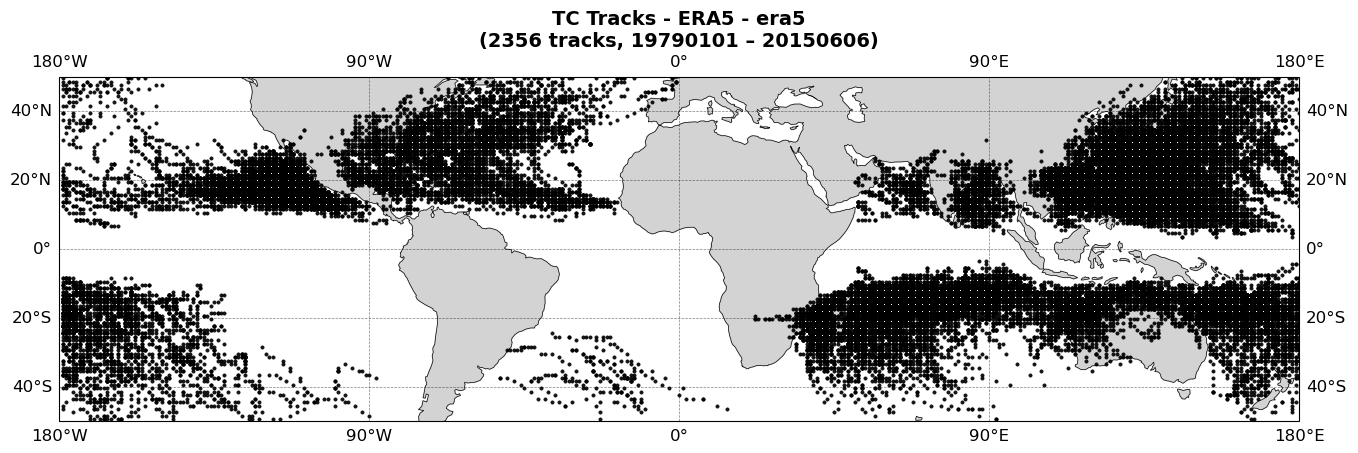

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_ERA5_era5_19790101_20150606.nc


In [10]:
# ===========================================
# 6: plots using tc_data in memory
# ===========================================
plot_trajectories_direct(tc_data, config)   

Using data from memory (fast)
Plotting all 2349 storms colored by category
Plotting storms ordered: weak (background) → strong (foreground)
✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_colored_category_ERA5_era5_19790101_20150106.pdf


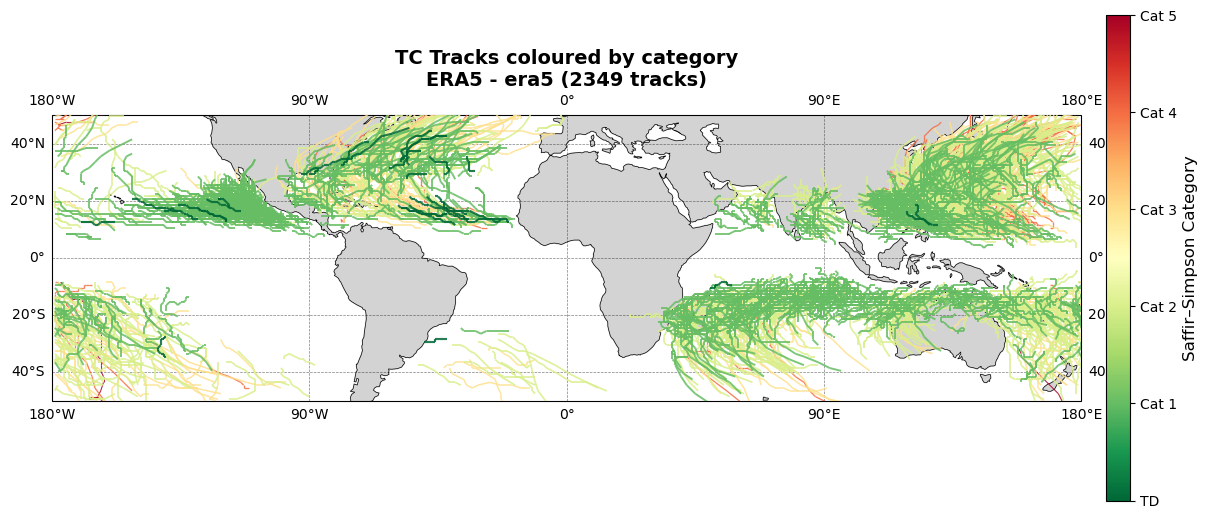

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_colored_category_ERA5_era5_19790101_20150106.nc


In [13]:
# OPZIONE 1: Tutte le traiettorie colorate per categoria
#plot_trajectories_colored(tc_data, config, color_by='category')
plot_trajectories_colored(tc_data, config)  
# → Salva: tracks_colored_category_MODEL_EXP_DATE.pdf/nc

Using data from memory (fast)
Filtering for Cat 4 (945–959)...
✓ Found 98 trajectories for Cat 4 (945–959)


/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)
/work/users/mccorda/miniforge3/envs/aqua-diagnostics

✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_cat4_ERA5_era5_19790101_20150106.pdf


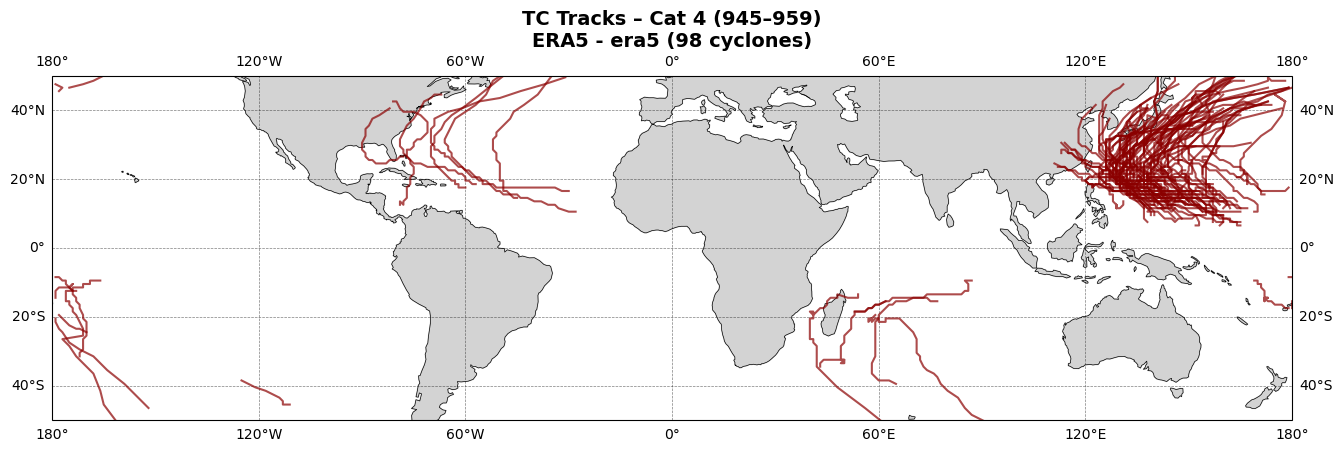

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_cat4_ERA5_era5_19790101_20150106.nc


In [14]:
# OPZIONE 2: Solo Cat 4
plot_trajectories_colored(tc_data, config, category=4)
# → Salva: tracks_cat4_MODEL_EXP_DATE.pdf/nc

Using data from memory (fast)
Filtering for Cat 5 (<945)...
✓ Found 7 trajectories for Cat 5 (<945)


/work/users/mccorda/miniforge3/envs/aqua-diagnostics/lib/python3.12/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)


✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_cat5_ERA5_era5_19790101_20150106.pdf


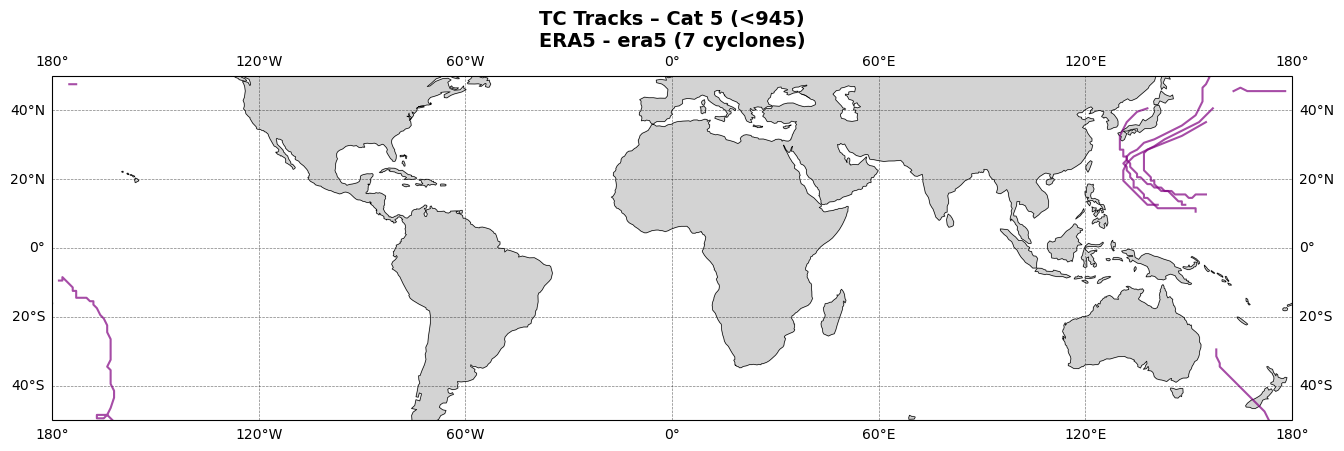

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/tracks_cat5_ERA5_era5_19790101_20150106.nc


In [15]:
# OPZIONE 3: Solo Cat 5
plot_trajectories_colored(tc_data, config, category=5)
# → Salva: tracks_cat5_MODEL_EXP_DATE.pdf/nc

Using data from memory (fast)
Total TC observation points: 54,514
Sampling 50,000 points for KDE...
Computing KDE...


✓ Plot saved: /work/users/mccorda/tc_analysis/Figures/density_scatter_ERA5_era5_19790101_20150106.pdf


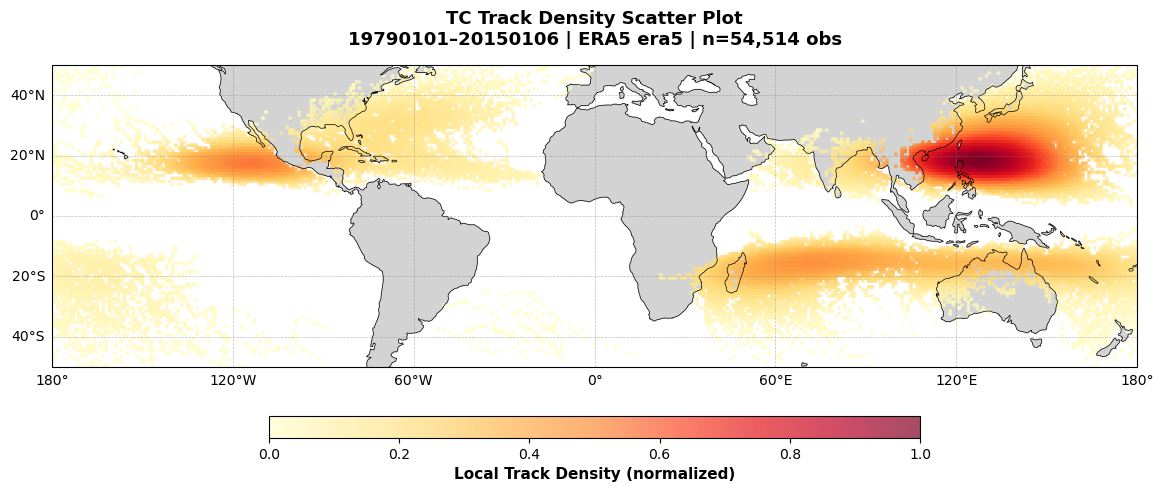

In [12]:
plot_density_scatter(tc_data, config) 

Using data from memory (fast)
Total TC observation points: 54,514
Time period: 433 months
Data range: 0.0023 - 0.14 transits/month
Colorbar range: 0.0100 - 0.15
Colorbar boundaries: [0.         0.01253163 0.01570418 0.0196799  0.02466212 0.03090566
 0.03872983 0.0485348  0.06082202 0.07621991 0.09551598 0.11969711
 0.15      ]
✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106.pdf


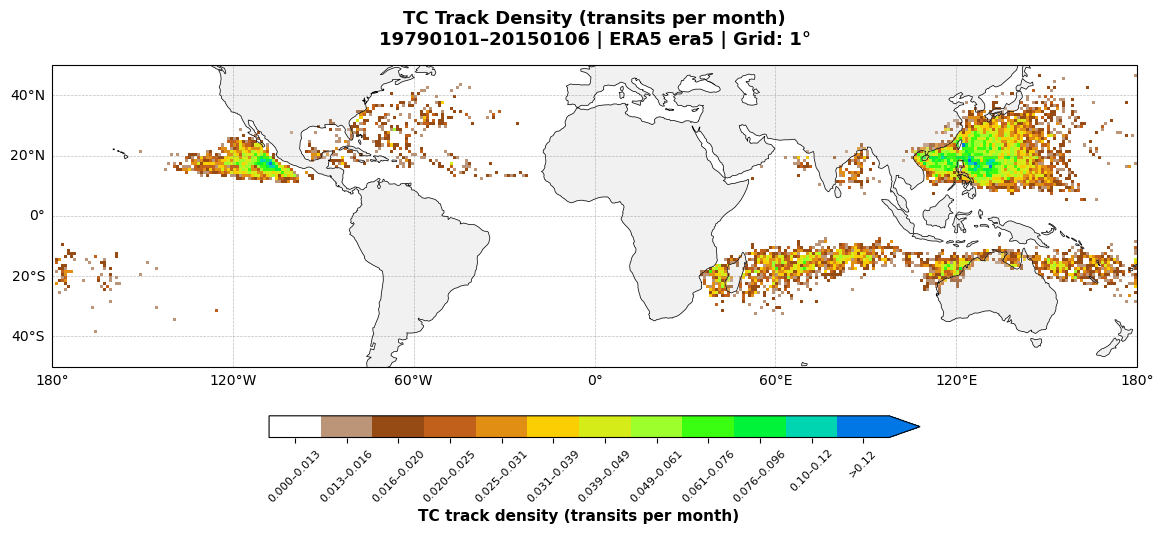

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106.nc
  Grid dimensions: 100 lat × 360 lon
  Data variables: transits_per_month, count, transits_discrete


In [13]:
# Plot di tutti i TC
plot_track_density_grid(tc_data, config, grid_size=1)

Using data from memory (fast)
Filtering for Cat 3 (960–974 hPa) and stronger...
✓ Found 430 storms with peak intensity ≥ Cat 3 (960–974 hPa)
Total TC observation points: 14,244
Time period: 433 months
Data range: 0.0023 - 0.09 transits/month
Colorbar range: 0.0100 - 0.10
Colorbar boundaries: [0.         0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1       ]


✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106_cat3plus.pdf


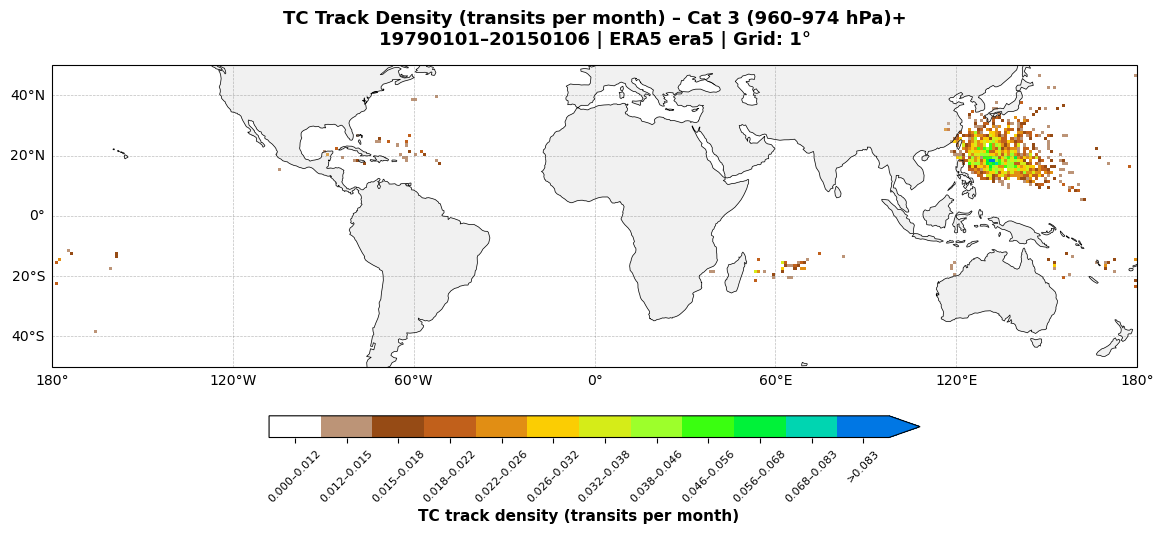

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106_cat3plus.nc
  Grid dimensions: 100 lat × 360 lon
  Data variables: transits_per_month, count, transits_discrete


In [14]:
# Solo Major Hurricanes (Cat 3+)
plot_track_density_grid(tc_data, config, category=3)

Using data from memory (fast)
Filtering for Cat 4 (945–959 hPa) and stronger...
✓ Found 105 storms with peak intensity ≥ Cat 4 (945–959 hPa)
Total TC observation points: 3,822
Time period: 433 months
Data range: 0.0023 - 0.05 transits/month
Colorbar range: 0.0100 - 0.10
Colorbar boundaries: [0.         0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1       ]
✓ PDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106_cat4plus.pdf


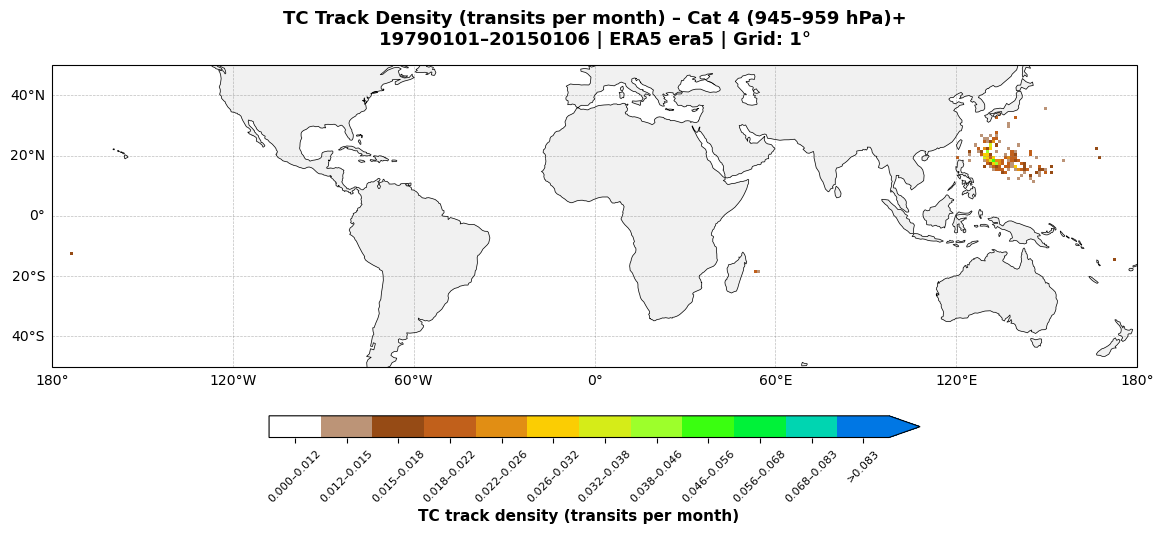

✓ NetCDF saved to: /work/users/mccorda/tc_analysis/Figures/track_density_grid_ERA5_era5_19790101_20150106_cat4plus.nc
  Grid dimensions: 100 lat × 360 lon
  Data variables: transits_per_month, count, transits_discrete


In [15]:
# Cat 4 plus
plot_track_density_grid(tc_data, config, grid_size=1, category=4)

Using data from memory (fast)

Points per category:
  Cat 0: 5,184 points
  Cat 1: 33,760 points
  Cat 2: 11,777 points
  Cat 3: 3,281 points
  Cat 4: 489 points
  Cat 5: 23 points
✓ 6-panel plot saved: /work/users/mccorda/tc_analysis/Figures/density_scatter_by_category_ERA5_era5_19790101_20150106.pdf


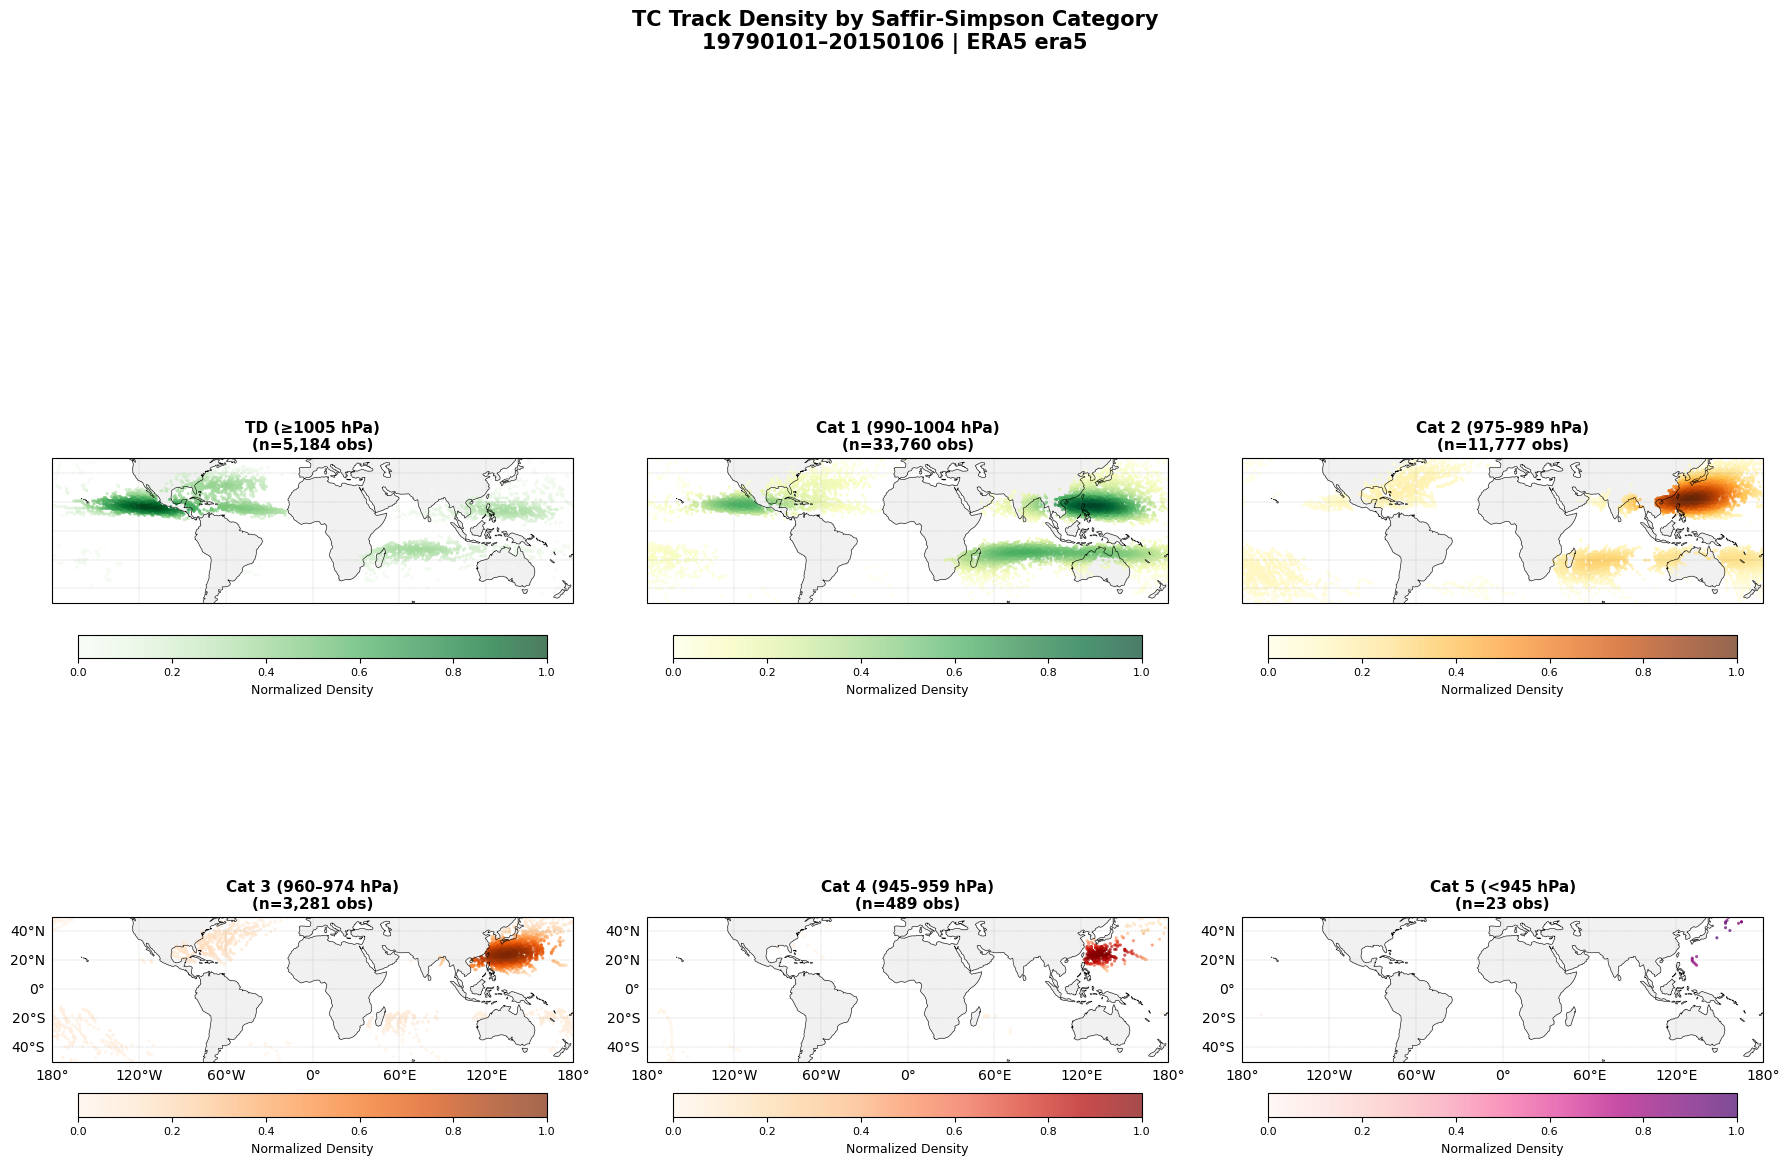

In [16]:
plot_density_scatter_by_category(tc_data, config) 

Computing TC duration statistics from memory...
Using data from memory (fast)

TC DURATION STATISTICS
Total cyclones: 2349
Mean duration: 5.6 days
Median duration: 4.8 days
Min duration: 2.2 days (54 hours)
Max duration: 20.8 days
Std deviation: 2.8 days
✓ Duration distribution saved: /work/users/mccorda/tc_analysis/Figures/tc_duration_distribution_ERA5_era5_19790101_20150106.pdf


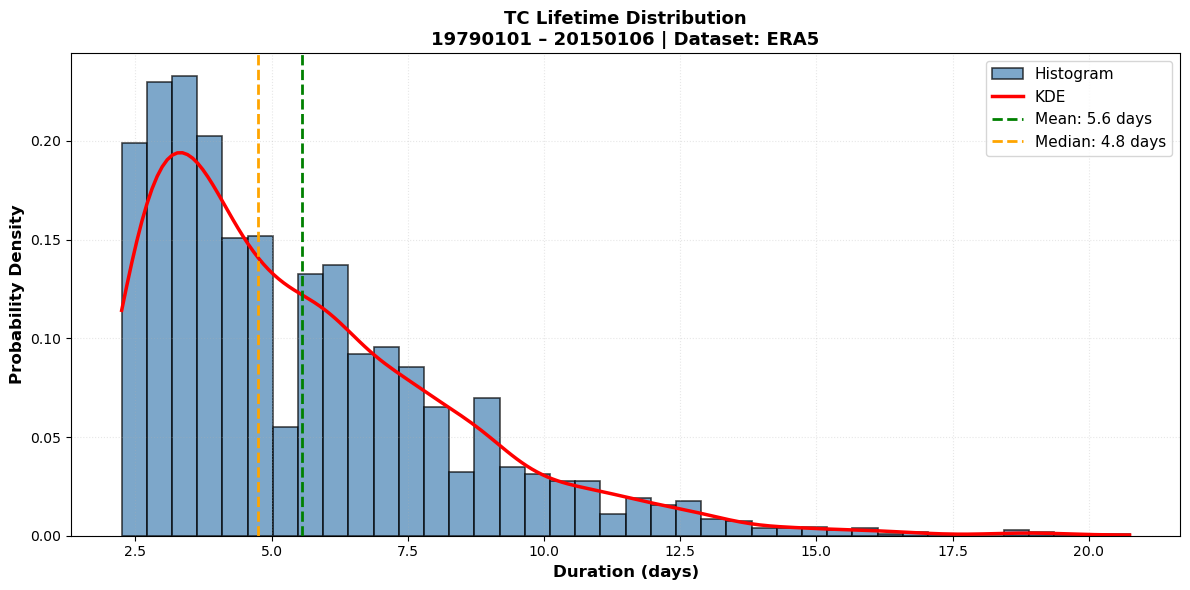

In [11]:
# Duration distribution
plot_tc_duration_distribution(tc_data, config)

Computing TC duration by category from memory...
Using data from memory (fast)

TC count per category:
  Cat 0: 30 storms, mean duration: 3.5 days
  Cat 1: 1108 storms, mean duration: 4.3 days
  Cat 2: 781 storms, mean duration: 6.1 days
  Cat 3: 325 storms, mean duration: 7.8 days
  Cat 4: 98 storms, mean duration: 8.9 days
  Cat 5: 7 storms, mean duration: 7.9 days
✓ Normalized duration histogram saved: /work/users/mccorda/tc_analysis/Figures/tc_duration_normalized_by_category_ERA5_era5_19790101_20150106.pdf


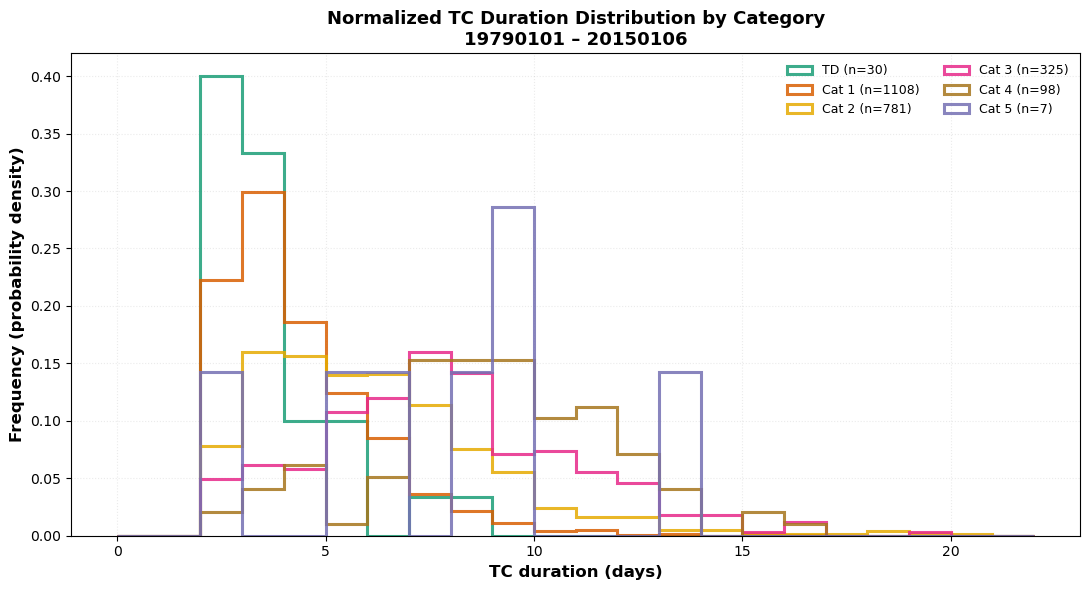

In [12]:
# Duration by category (normalized)
plot_tc_duration_by_category(tc_data, config)

Computing basin frequencies from memory...
Using data from memory (fast)
Period: 1979-2014 (35 years)

Annual frequencies (storms/year):
  NH total: 40.4
  SH total: 23.3
    North Atlantic: 8.6
    East Pacific: 7.9
    West Pacific: 21.6
    North Indian: 2.3
    South Indian: 14.0
    South Pacific: 9.3
✓ Doughnut chart saved: /work/users/mccorda/tc_analysis/Figures/tc_doughnut_frequency_ERA5_era5_19790101_20150106.pdf


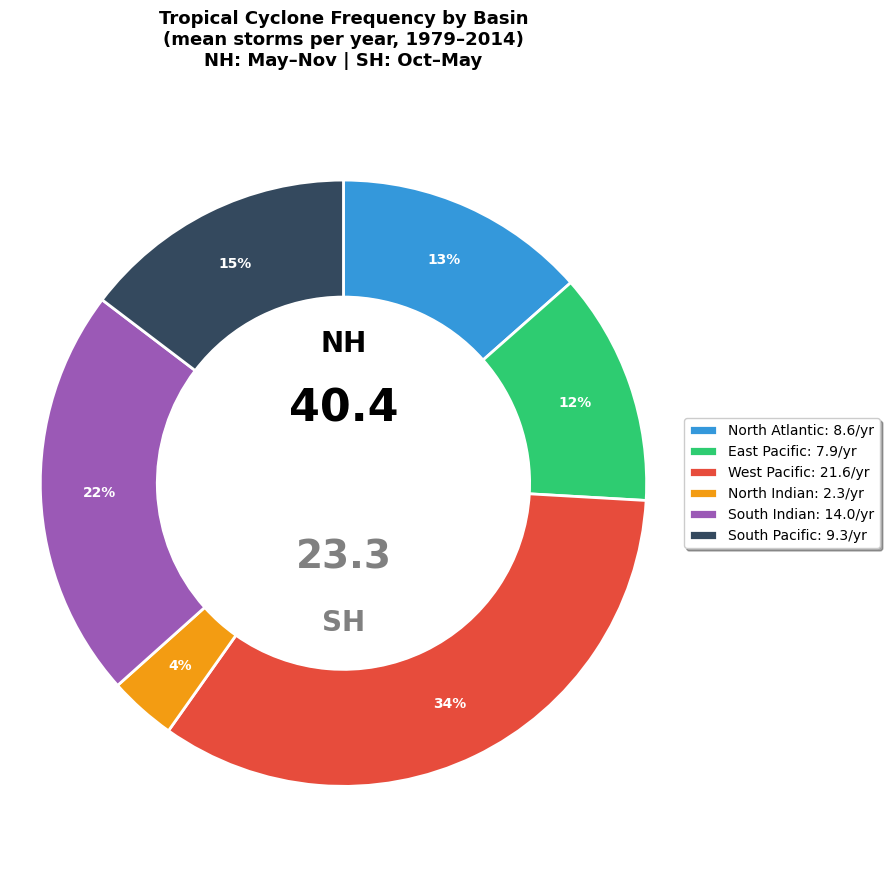


COMPARISON WITH ROBERTS ET AL. (2020)
Basin                This study         Roberts et al.     Difference     
----------------------------------------------------------------------
North Atlantic                    8.6             12.5     -3.9 (-31%)
East Pacific                      7.9             16.0     -8.1 (-51%)
West Pacific                     21.6             25.0     -3.4 (-14%)
North Indian                      2.3              5.5     -3.2 (-58%)
South Indian                     14.0             10.0      4.0 (+40%)
South Pacific                     9.3              4.5      4.8 (+108%)
----------------------------------------------------------------------
NH Total                         40.4             59.0    -18.6 (-32%)
SH Total                         23.3             14.5      8.8 (+61%)
✓ Comparison chart saved: /work/users/mccorda/tc_analysis/Figures/tc_frequency_comparison_ERA5_era5_19790101_20150106.pdf


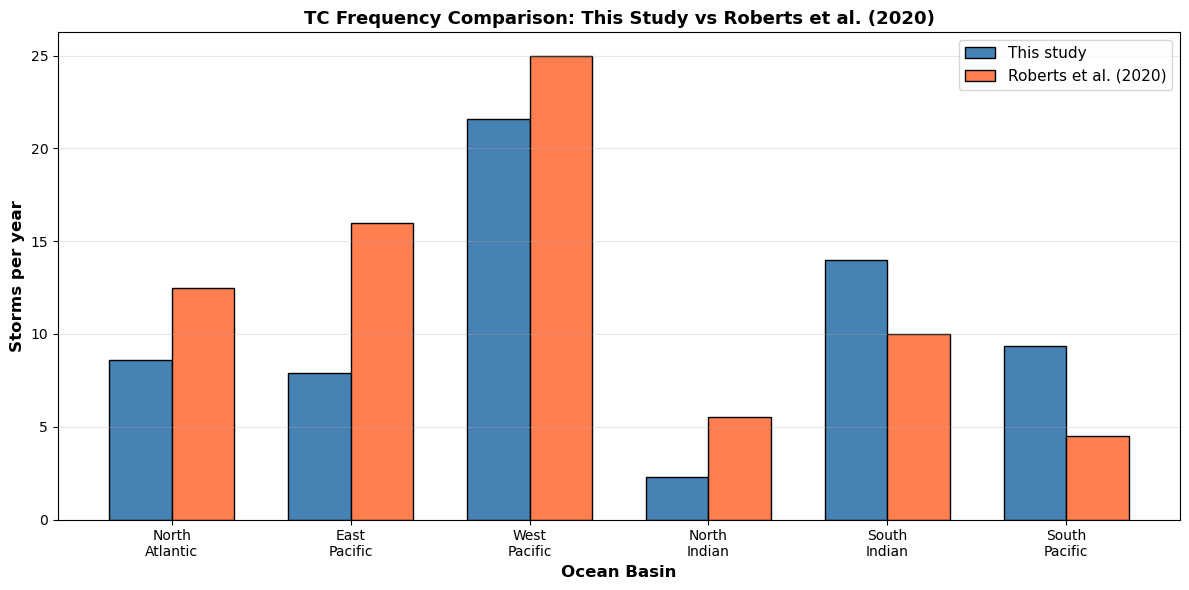

✓ Basin analysis complete!


In [13]:
# Basin doughnut + comparison
plot_tc_basin_doughnut(tc_data, config)

In [12]:
client.shutdown()
cluster.close()